In [2]:
!pip install tqdm
!pip install networkx

In [1]:
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from collections import defaultdict
from networkx.algorithms.community import louvain_communities
from collections import defaultdict
from networkx.algorithms.community import louvain_communities
import matplotlib.cm as cm
from sklearn.metrics import jaccard_score
from itertools import combinations
import matplotlib.colors as mcolors

In [3]:
# Step 1: Load the CSV File with Progress Bar
file_path = 'reviews_data.csv'

print("Loading the CSV file...")

# Use tqdm to simulate progress if loading takes time
with tqdm(total=1, desc="Loading CSV", unit="file") as pbar:
    reviews_df = pd.read_csv(file_path)
    pbar.update(1)

print("CSV file loaded successfully!")
print(reviews_df.head())  # Display first few rows

Loading the CSV file...


Loading CSV: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.89s/file]

CSV file loaded successfully!
    productId          userId                                 profileName  \
0  B003AI2VGA  A141HP4LYPWMSR            Brian E. Erland "Rainbow Sphinx"   
1  B003AI2VGA  A328S9RN3U5M68                                  Grady Harp   
2  B003AI2VGA  A1I7QGUDP043DG                   Chrissy K. McVay "Writer"   
3  B003AI2VGA  A1M5405JH9THP9                                golgotha.gov   
4  B003AI2VGA   ATXL536YX71TR  KerrLines "&#34;Movies,Music,Theatre&#34;"   

  helpfulness  score        time  \
0         7/7    3.0  1182729600   
1         4/4    3.0  1181952000   
2        8/10    5.0  1164844800   
3         1/1    3.0  1197158400   
4         1/1    3.0  1188345600   

                                             summary  \
0  "There Is So Much Darkness Now ~ Come For The ...   
1  Worthwhile and Important Story Hampered by Poo...   
2                      This movie needed to be made.   
3                  distantly based on a real tragedy   
4  "What's

In [4]:
reviews_df.info()
reviews_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5236601 entries, 0 to 5236600
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   productId    object 
 1   userId       object 
 2   profileName  object 
 3   helpfulness  object 
 4   score        float64
 5   time         int64  
 6   summary      object 
 7   text         object 
dtypes: float64(1), int64(1), object(6)
memory usage: 319.6+ MB


,productId,userId,profileName,helpfulness,score,time,summary,text
0,B003AI2VGA,A141HP4LYPWMSR,"Brian E. Erland ""Rainbow Sphinx""",7/7,3.0,1182729600,"""There Is So Much Darkness Now ~ Come For The ...",Synopsis
1,B003AI2VGA,A328S9RN3U5M68,Grady Harp,4/4,3.0,1181952000,Worthwhile and Important Story Hampered by Poo...,THE VIRGIN OF JUAREZ is based on true events s...
2,B003AI2VGA,A1I7QGUDP043DG,"Chrissy K. McVay ""Writer""",8/10,5.0,1164844800,This movie needed to be made.,The scenes in this film can be very disquietin...
3,B003AI2VGA,A1M5405JH9THP9,golgotha.gov,1/1,3.0,1197158400,distantly based on a real tragedy,THE VIRGIN OF JUAREZ (2006)<br />directed by K...
4,B003AI2VGA,ATXL536YX71TR,"KerrLines ""&#34;Movies,Music,Theatre&#34;""",1/1,3.0,1188345600,"""What's going on down in Juarez and shining a ...","Informationally, this SHOWTIME original is ess..."


In [5]:
reviews_df = reviews_df.drop(reviews_df.index[:5230000])

In [6]:
reviews_df.shape

(6601, 8)

In [7]:
# Save the modified DataFrame to a new CSV file
reviews_df.to_csv("edited_reviews.csv", index=False)

In [8]:
B = nx.Graph()

print("Creating the bipartite graph...")

# Use tqdm to track progress of adding edges
for index, row in tqdm(reviews_df.iterrows(), desc="Adding edges", total=len(reviews_df)):
    user = row['userId']
    product = row['productId']
    B.add_edge(user, product)

# Output number of nodes and edges
print(f"Number of nodes: {B.number_of_nodes()}")
print(f"Number of edges: {B.number_of_edges()}")


Creating the bipartite graph...


Adding edges: 100%|█████████████████████████████████████████████████████████████| 6601/6601 [00:00<00:00, 35554.63it/s]

Number of nodes: 5924
Number of edges: 6538


In [11]:
# Step 1: Create the User-Product Bipartite Network
B = nx.Graph()

# Add user and product nodes with bipartite attribute
B.add_nodes_from(reviews_df['userId'].unique(), bipartite='user')
B.add_nodes_from(reviews_df['productId'].unique(), bipartite='product')

# Add edges between users and products they reviewed
B.add_edges_from(reviews_df[['userId', 'productId']].drop_duplicates().itertuples(index=False, name=None))

# Display node types and example nodes
user_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 'user'}
product_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 'product'}

print("User Nodes (representing users who reviewed products):")
print(list(user_nodes)[:10])  # Displaying first 10 users for brevity

print("\nProduct Nodes (representing products that were reviewed):")
print(list(product_nodes)[:10])  # Displaying first 10 products for brevity

# Display edges and what they represent
edges = list(B.edges(data=True))
print("\nEdges (representing user-product reviews):")
print(edges[:10])  # Displaying first 10 edges for brevity

User Nodes (representing users who reviewed products):
['A2XK9W52YI1HQR', 'AWF5S3F9CCQKT', 'A15G4BU9DKBI6X', 'A2ZD69RKOHL2Q4', 'A1UKJF6YPSSZ1Q', 'A2RSDZALWQ0YP6', 'A304AP38FGV1RH', 'A2AN6T6EA9ARE0', 'A1M9DQDGE07Q0U', 'A13APTAKS8AMX5']

Product Nodes (representing products that were reviewed):
['0972928421', '1420888048', 'B00018U9JI', 'B000UP883G', 'B0009XT8U6', 'B003BV8I5Y', 'B002LNG9OU', 'B000SK5Z84', 'B000CEV3K0', 'B00008V2V9']

Edges (representing user-product reviews):
[('A1K4VAYQQLNFVS', 'B00005MAYB', {}), ('ALNF2JWN3URSH', 'B00005MAYB', {}), ('ALNF2JWN3URSH', '6305075468', {}), ('AVIOOR3E66J3H', 'B00005MAYB', {}), ('A227TR9A30HOCV', 'B00005MAYB', {}), ('A329TTW9VJ2NBU', 'B00005MAYB', {}), ('A329TTW9VJ2NBU', 'B000K2EQBW', {}), ('A2Q07KQAAFWVL7', 'B00005MAYB', {}), ('A2Q07KQAAFWVL7', 'B00005MAYF', {}), ('A1NAGYEOC6ZEHW', 'B00005MAYB', {})]


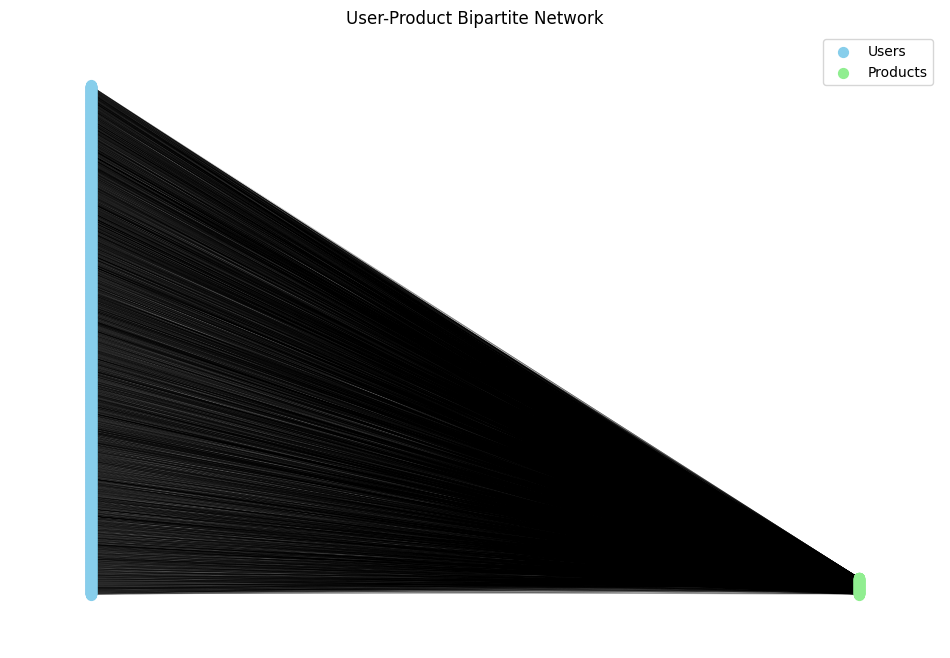

In [9]:
# Step 1: Create the User-Product Bipartite Network
B = nx.Graph()

# Add user and product nodes with bipartite attribute
B.add_nodes_from(reviews_df['userId'].unique(), bipartite='user')
B.add_nodes_from(reviews_df['productId'].unique(), bipartite='product')

# Add edges between users and products they reviewed
B.add_edges_from(reviews_df[['userId', 'productId']].drop_duplicates().itertuples(index=False, name=None))

# Step 2: Separate user and product nodes for visualization purposes
user_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 'user'}
product_nodes = set(B) - user_nodes

# Step 3: Plot the Bipartite Graph
plt.figure(figsize=(12, 8))

# Define positions using bipartite layout
pos = {node: (1, index) for index, node in enumerate(user_nodes)}
pos.update({node: (2, index) for index, node in enumerate(product_nodes)})

# Draw nodes with different colors for users and products
nx.draw_networkx_nodes(B, pos, nodelist=user_nodes, node_color='skyblue', node_size=50, label="Users")
nx.draw_networkx_nodes(B, pos, nodelist=product_nodes, node_color='lightgreen', node_size=50, label="Products")

# Draw edges
nx.draw_networkx_edges(B, pos, alpha=0.5, width=0.2)

# Add labels
plt.legend(["Users", "Products"])
plt.title("User-Product Bipartite Network")
plt.axis('off')  # Hide axes for a cleaner look
plt.show()

USING JACCARD SIMILARITY FOR RECOMMENDING SIMILAR PRODUCTS TO THE USERS

In [10]:
# Step 1: Create the User-Product Bipartite Network
B = nx.Graph()

# Add user and product nodes with bipartite attribute
B.add_nodes_from(reviews_df['userId'].unique(), bipartite='user')
B.add_nodes_from(reviews_df['productId'].unique(), bipartite='product')

# Add edges between users and products they reviewed
B.add_edges_from(reviews_df[['userId', 'productId']].drop_duplicates().itertuples(index=False, name=None))

# Step 2: Create a product-user matrix
# Pivot the data to create a binary matrix where rows are products and columns are users
product_user_matrix = reviews_df.pivot_table(index='productId', columns='userId', aggfunc='size', fill_value=0)

# Step 3: Calculate Jaccard Similarity between products
# Initialize a dictionary to hold product similarity scores
similarity_dict = {}

for prod1, prod2 in combinations(product_user_matrix.index, 2):
    # Calculate Jaccard similarity with average='macro'
    similarity = jaccard_score(product_user_matrix.loc[prod1], product_user_matrix.loc[prod2], average='macro')
    if similarity > 0:  # Only store similarities above 0
        similarity_dict[(prod1, prod2)] = similarity

# Step 4: Build a recommendation function based on product similarity
def recommend_similar_products(product_id, top_n=5):
    # Get all product pairs that include the specified product_id
    similar_products = {p: sim for (p1, p2), sim in similarity_dict.items() 
                        if (p1 == product_id or p2 == product_id) 
                        and (p := p2 if p1 == product_id else p1)}
    
    # Sort similar products by similarity score in descending order
    sorted_similar_products = sorted(similar_products.items(), key=lambda x: x[1], reverse=True)
    
    # Return the top N similar products
    return [prod for prod, sim in sorted_similar_products[:top_n]]

# Example: Recommend similar products for a specific product
product_id = '0972928421'  # Replace with a productId of your choice
recommended_products = recommend_similar_products(product_id)
print("Recommended products similar to product", product_id, ":", recommended_products)

Recommended products similar to product 0972928421 : ['0767017382', '6301261070', '6302670241', '6302892201', '6303814298']


BASED ON CENTRALITIES WE TAKE OUT TOP 10 INFLUENCERS(USER_ID) IN THE NETWORK GRAPH

In [11]:
# Step 1: Create the User-Product Bipartite Network
B = nx.Graph()

# Add user and product nodes with bipartite attribute
B.add_nodes_from(reviews_df['userId'].unique(), bipartite='user')
B.add_nodes_from(reviews_df['productId'].unique(), bipartite='product')

# Add edges between users and products they reviewed
B.add_edges_from(reviews_df[['userId', 'productId']].drop_duplicates().itertuples(index=False, name=None))

# Step 2: Calculate Centrality Measures
# Only focus on user nodes for identifying influencers
user_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 'user'}

# Degree Centrality
degree_centrality = nx.degree_centrality(B)
user_degree_centrality = {node: degree_centrality[node] for node in user_nodes}

# Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(B, max_iter=1000)
user_eigenvector_centrality = {node: eigenvector_centrality[node] for node in user_nodes}

# Step 3: Combine Centrality Measures into a DataFrame
centrality_df = pd.DataFrame({
    'degree_centrality': pd.Series(user_degree_centrality),
    'eigenvector_centrality': pd.Series(user_eigenvector_centrality),
})

# Optional: Use average rank if you want to consider both measures together
centrality_df['average_rank'] = centrality_df.rank(ascending=False).mean(axis=1)
top_influencers = centrality_df.sort_values(by='average_rank').head(10)

# Display Top Influencers
print("Top 10 Influencers Based on Centrality Measures:")
print(top_influencers)


Top 10 Influencers Based on Centrality Measures:
                degree_centrality  eigenvector_centrality  average_rank
AJKWF4W7QD4NS            0.001351                0.041209          5.25
AWG2O9C42XW5G            0.001182                0.041378          7.25
A1JH5J1KQAUBMP           0.001013                0.042335         11.00
A1NI0VOVXZBM7Y           0.001351                0.037494         12.75
A1GHUN5HXMHZ89           0.001013                0.039528         13.50
A2B73CL3QSYWLB           0.001013                0.038608         15.50
A1ER6IYOMM8VCT           0.001013                0.037145         20.00
AER15RIMV8E6D            0.000844                0.037779         24.75
A2A6NH6DPE0VXR           0.000675                0.040341         30.50
A3H9JSM1SUTE4O           0.000675                0.039772         31.00


If you only need to identify top influencers based on degree centrality and eigenvector centrality, using average rank may not be necessary. Instead, you could rank users by either degree or eigenvector centrality individually or sort them by one primary measure (e.g., eigenvector centrality) for influence. However, using average rank allows you to consider both metrics simultaneously, balancing users with high connections (degree) and those connected to influential nodes (eigenvector).

PRODUCTS MOST POPULAR AMONG USERS

Review Count: Measures how many users have engaged with a product, indicating its popularity or visibility. High review counts suggest the product is widely known or frequently purchased.

Average Score: Reflects the quality of the product as rated by users. High average scores suggest that users generally like the product, making it a good indicator of satisfaction.

Combined Popularity Score: Balances both quantity (review count) and quality (average score) by normalizing and averaging them. This metric helps highlight products that are not only popular but also well-rated, providing a holistic view of "popularity" that considers both user engagement and satisfaction.

In [12]:
import pandas as pd

# Step 1: Calculate the Number of Reviews for Each Product
product_review_counts = reviews_df.groupby('productId').size()
product_review_counts.name = 'review_count'

# Step 2: Calculate the Average Review Score for Each Product
product_average_scores = reviews_df.groupby('productId')['score'].mean()
product_average_scores.name = 'average_score'

# Step 3: Combine the Review Count and Average Score into a Popularity Metric
# Normalize review counts and average scores, then combine them
product_popularity = pd.DataFrame({
    'review_count': product_review_counts,
    'average_score': product_average_scores
})
product_popularity['normalized_review_count'] = (product_popularity['review_count'] - product_popularity['review_count'].min()) / (product_popularity['review_count'].max() - product_popularity['review_count'].min())
product_popularity['normalized_average_score'] = (product_popularity['average_score'] - product_popularity['average_score'].min()) / (product_popularity['average_score'].max() - product_popularity['average_score'].min())

# Combined popularity score: average of normalized review count and normalized average score
product_popularity['popularity_score'] = (product_popularity['normalized_review_count'] + product_popularity['normalized_average_score']) / 2

# Step 4: Identify Top Products by Popularity Metrics
top_products_by_reviews = product_popularity.sort_values(by='review_count', ascending=False).head(5)
top_products_by_score = product_popularity.sort_values(by='average_score', ascending=False).head(5)
top_products_by_popularity_score = product_popularity.sort_values(by='popularity_score', ascending=False).head(5)

# Display the Results
print("\nTop 10 Products by Combined Popularity Score:\n", top_products_by_popularity_score)


Top 10 Products by Combined Popularity Score:
             review_count  average_score  normalized_review_count  \
productId                                                          
B008Y5QTRG           413       4.312349                 1.000000   
B000K2EQBW           321       4.464174                 0.776699   
B00004YA6S           302       4.470199                 0.730583   
B00004TXKE           242       4.607438                 0.584951   
6305603847           221       4.488688                 0.533981   

            normalized_average_score  popularity_score  
productId                                               
B008Y5QTRG                  0.828087          0.914044  
B000K2EQBW                  0.866044          0.821371  
B00004YA6S                  0.867550          0.799066  
B00004TXKE                  0.901860          0.743405  
6305603847                  0.872172          0.703076  


IDENTIFYING TRUSTED USERS GIVING GENUINE REVIEWS

1.Calculate Average Scores: We calculate the average score for each product across all reviews, giving a baseline for what an "average" score looks like for each product.

2.Calculate Deviation: For each review, we measure the deviation (difference) between the user’s rating and the product’s average score. Lower deviation means the user’s rating is closer to the consensus, suggesting reliability in their judgment.

3.Identify Trusted Reviewers: We calculate the average deviation for each user. Users with an average deviation below a threshold (e.g., 0.5) are considered "trusted" because their ratings are consistently close to the product's average.

4.Analyze Network Influence: We examine the network influence (centrality) of trusted reviewers within the user-product network, calculating degree centrality score. These scores help us understand the role of trusted users in connecting products and influencing the network.

Trusted Reviewers (based on low deviation):
userId
A102B8D74H64TO    0.347733
A1037N3HC0ULWJ    0.208333
A105CCKIWRGI3X    0.312349
A1063RA12KFL47    0.054054
A10E17YAU7JWR     0.488688
                    ...   
AZTDHDUTVOSCC     0.362319
AZWBKZGBFF072     0.231293
AZWF4YPLJSD7Y     0.244019
AZZJBLYV8COX0     0.481481
AZZM5MUOG0LRK     0.357143
Name: average_deviation, Length: 1839, dtype: float64
Trusted Reviewers with Degree Centrality:
                degree_centrality  average_deviation
userId                                              
A328S9RN3U5M68           0.001688           0.499828
A39CX0EE4BZCZC           0.001182           0.359552
A3UDYY6L2NH3JS           0.001182           0.479851
A3KF4IP2MUS8QQ           0.001182           0.499585
A1X054KUYG5V             0.001182           0.389600
...                           ...                ...
A29Z11Z35S6HSM           0.000169           0.333333
A29V6CJUWJDZSY           0.000169           0.392562
A29ULC3NUGTNWO           0

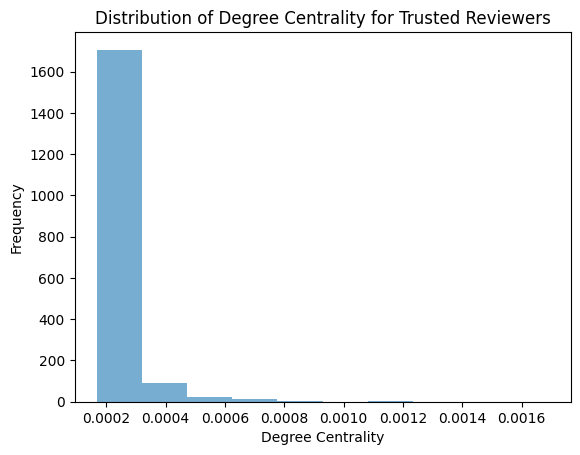

In [13]:
import pandas as pd
import networkx as nx

# Step 1: Calculate Average Scores for Each Product
product_average_scores = reviews_df.groupby('productId')['score'].mean()
product_average_scores.name = 'average_score'

# Step 2: Calculate Deviation for Each User's Ratings
# Merge product average scores with the reviews dataset
reviews_with_avg = reviews_df.merge(product_average_scores, on='productId', how='left')

# Calculate deviation from the product's average score for each review
reviews_with_avg['score_deviation'] = abs(reviews_with_avg['score'] - reviews_with_avg['average_score'])

# Step 3: Define Trusted Reviewers
# Calculate average deviation for each user
user_avg_deviation = reviews_with_avg.groupby('userId')['score_deviation'].mean()
user_avg_deviation.name = 'average_deviation'

# Set a threshold for trusted reviewers (e.g., users with average deviation < 0.5)
# You can adjust this threshold based on your dataset characteristics
trusted_reviewers = user_avg_deviation[user_avg_deviation < 0.5]
print("Trusted Reviewers (based on low deviation):")
print(trusted_reviewers)

# Step 4: Analyze Influence of Trusted Reviewers in the Network
# Create the user-product bipartite network
B = nx.Graph()
B.add_edges_from(reviews_df[['userId', 'productId']].drop_duplicates().itertuples(index=False, name=None))

# Calculate degree centrality for trusted reviewers
degree_centrality = nx.degree_centrality(B)

# Filter centrality measures for trusted reviewers only
trusted_reviewers_centrality = pd.DataFrame({
    'degree_centrality': trusted_reviewers.index.map(degree_centrality).fillna(0),
    'average_deviation': trusted_reviewers
})

# Display trusted reviewers with their centrality scores
print("Trusted Reviewers with Degree Centrality:")
print(trusted_reviewers_centrality.sort_values(by='degree_centrality', ascending=False))

# Optional: Visualize the distribution of trusted reviewers' degree centrality
trusted_reviewers_centrality['degree_centrality'].plot(kind='hist', alpha=0.6, title='Degree Centrality')
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")
plt.title("Distribution of Degree Centrality for Trusted Reviewers")
plt.show()


1.The plot is heavily skewed towards low degree centrality scores, with most trusted reviewers having a very low degree centrality (close to 0). This implies that,Most trusted reviewers have only reviewed a small number of products.Only a few trusted reviewers have high degree centrality, meaning they reviewed significantly more products than others.

2.The plot suggests that trusted reviewers (those with consistent scores) are not necessarily prolific reviewers. A few users stand out with more extensive reviews, which could indicate key influencers, while the majority are more limited in their product interactions.

WE APPLY COMMUNITY DETECTION TO USE IT AS A RECOMMENDATION SYSTEM

1.User-User Projection: Users are connected based on shared products they've reviewed, creating clusters of users with similar interests.

2.Product-Product Projection: Products are connected if they have been reviewed by the same users, forming clusters of related or co-reviewed products.

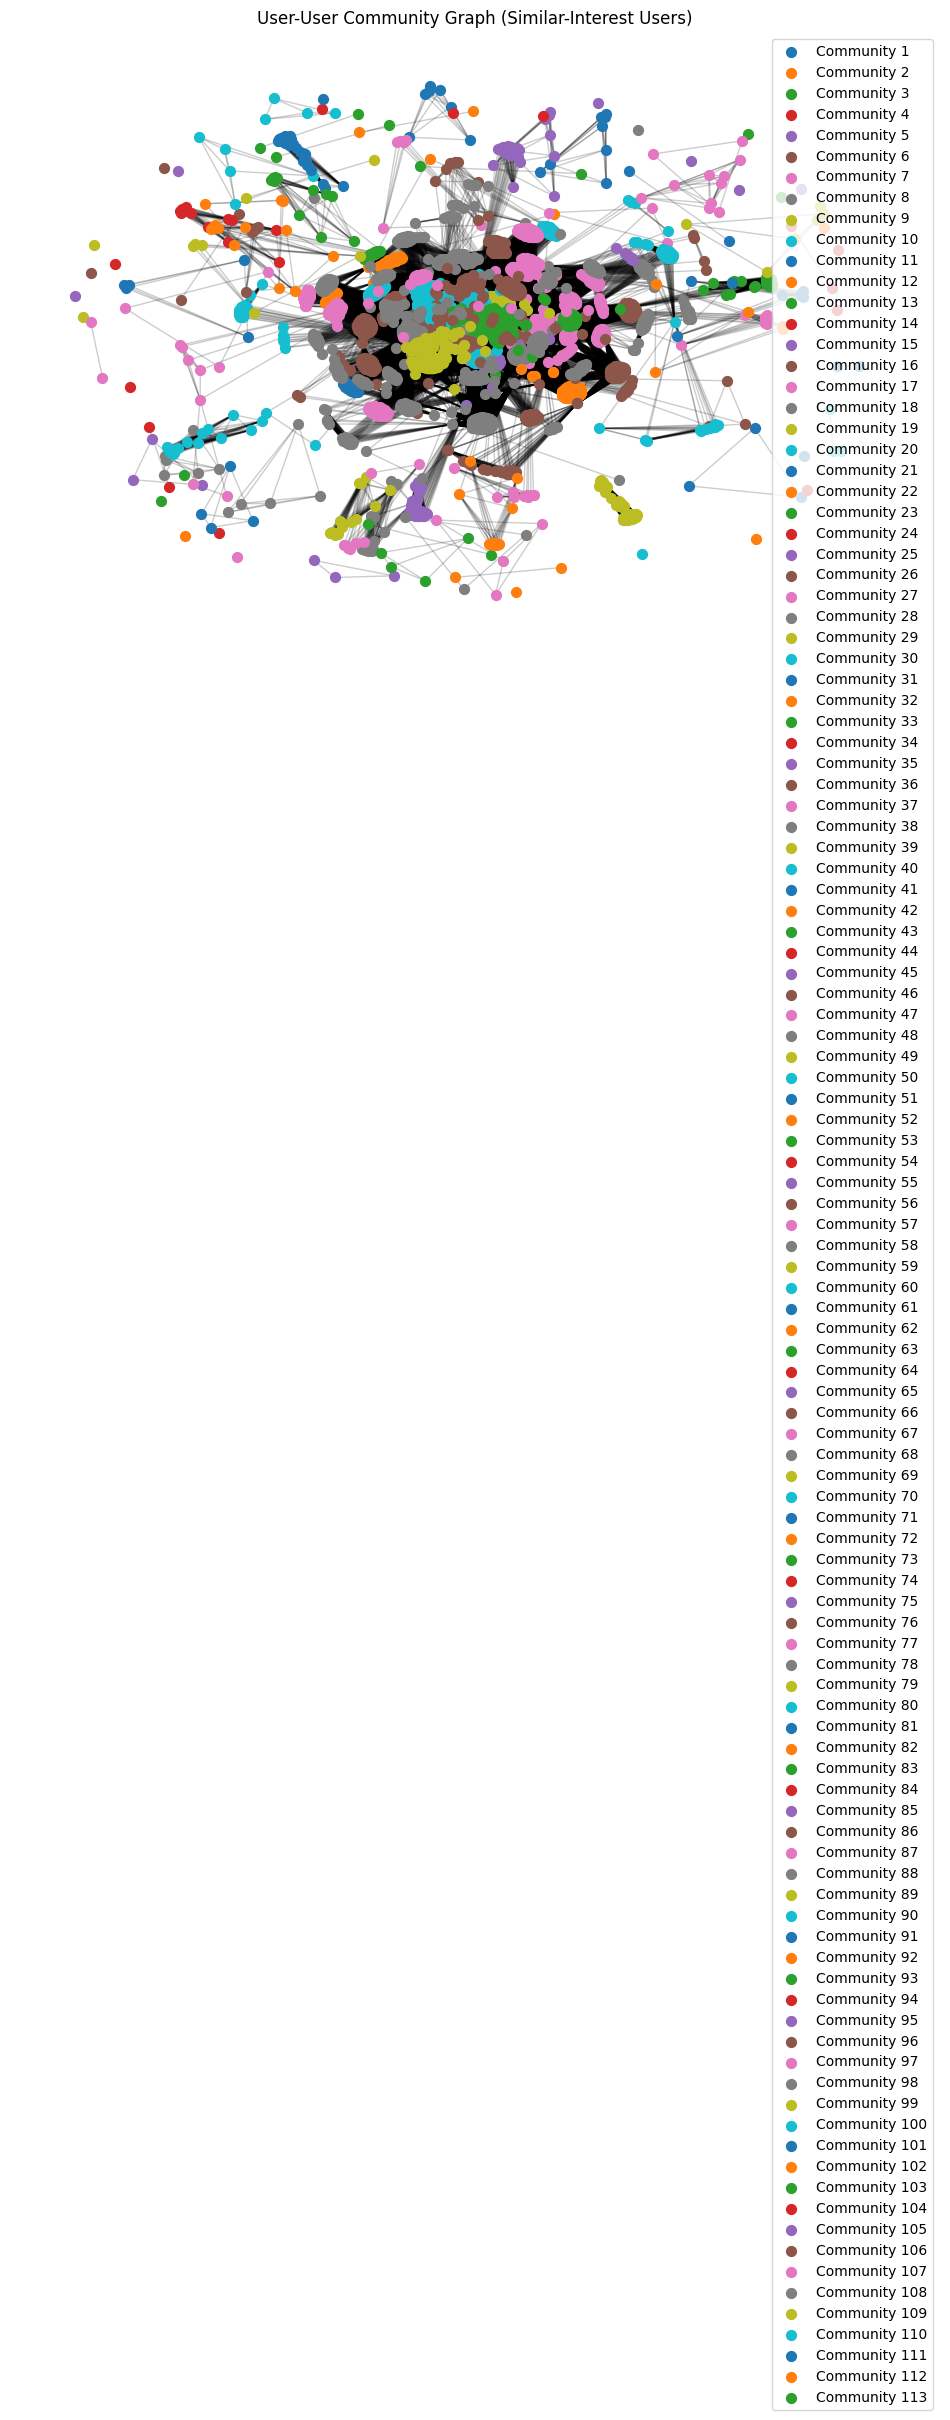

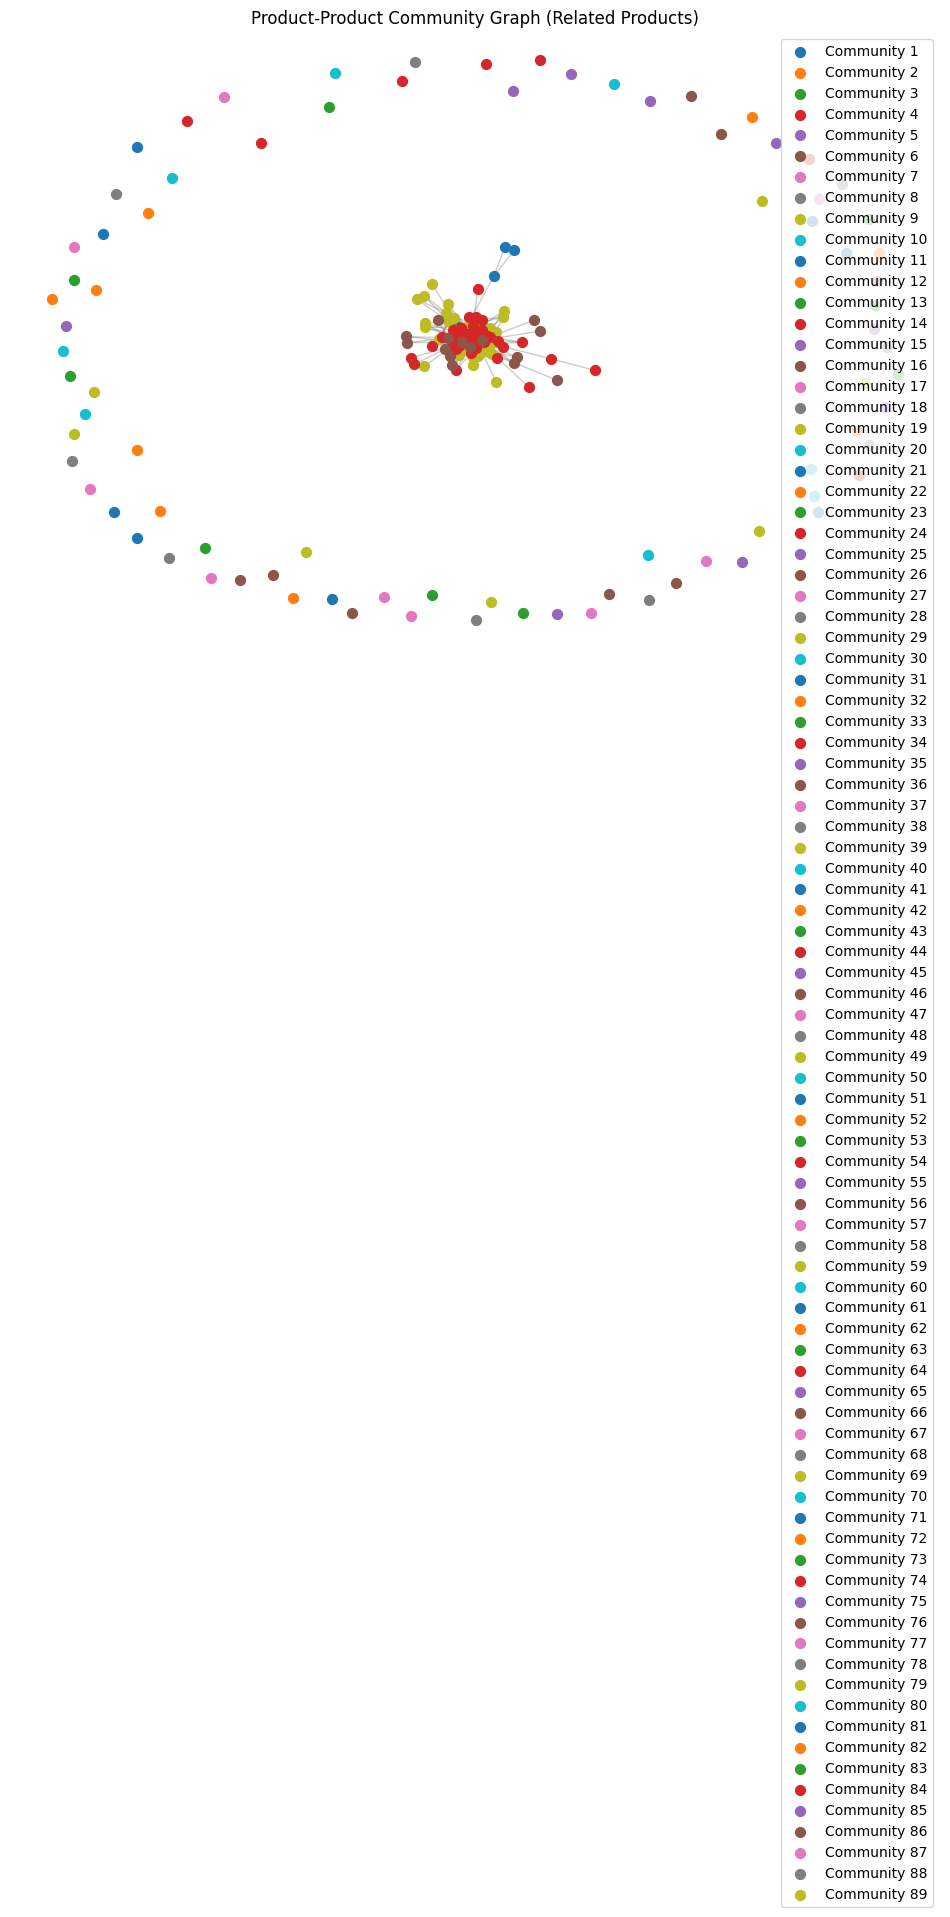

In [29]:
# Step 1: Create the User-Product Bipartite Network
B = nx.Graph()
B.add_nodes_from(reviews_df['userId'].unique(), bipartite='user')
B.add_nodes_from(reviews_df['productId'].unique(), bipartite='product')
B.add_edges_from(reviews_df[['userId', 'productId']].drop_duplicates().itertuples(index=False, name=None))

# Step 2: Project the Bipartite Network
user_projection = nx.bipartite.projected_graph(B, [n for n, d in B.nodes(data=True) if d['bipartite'] == 'user'])
product_projection = nx.bipartite.projected_graph(B, [n for n, d in B.nodes(data=True) if d['bipartite'] == 'product'])

# Step 3: Apply Community Detection
user_communities = louvain_communities(user_projection)
product_communities = louvain_communities(product_projection)

# Define colors for communities
colors = list(mcolors.TABLEAU_COLORS.values())

# Function to plot a graph with spring layout and community colors
def plot_community_graph(graph, communities, title):
    plt.figure(figsize=(12, 8))
    
    # Generate a position layout
    pos = nx.spring_layout(graph, k=0.1, seed=42)  # k controls spacing, adjust for clarity
    
    # Draw each community with a different color
    for i, community in enumerate(communities):
        color = colors[i % len(colors)]
        nx.draw_networkx_nodes(graph, pos, nodelist=community, node_size=50, node_color=color, label=f'Community {i + 1}')
    
    # Draw edges with low opacity
    nx.draw_networkx_edges(graph, pos, alpha=0.2)
    
    # Add labels (optional: can be omitted if graph is too dense)
    if len(graph.nodes) <= 100:  # Show labels if graph has 100 nodes or less
        nx.draw_networkx_labels(graph, pos, font_size=8)
    
    # Add legend and title
    plt.legend(loc='best')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Step 4: Plot the User-User and Product-Product Projections
plot_community_graph(user_projection, user_communities, "User-User Community Graph (Similar-Interest Users)")
plot_community_graph(product_projection, product_communities, "Product-Product Community Graph (Related Products)")


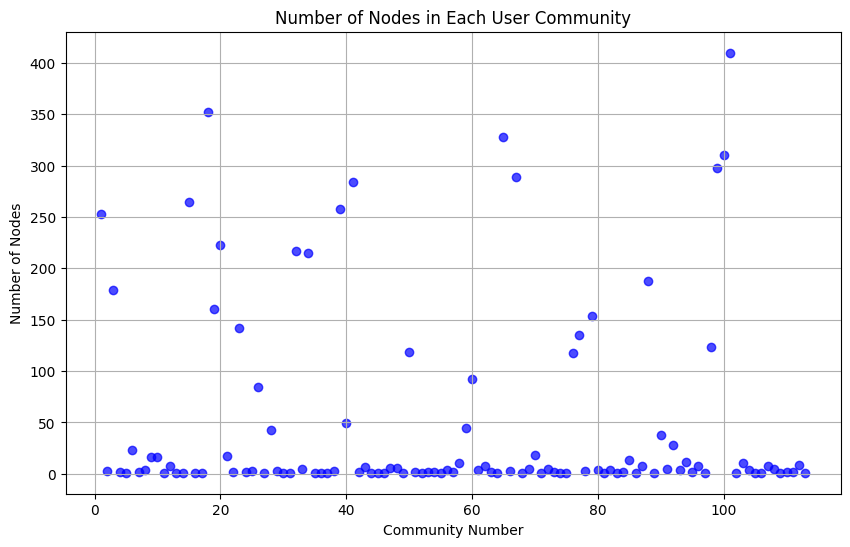

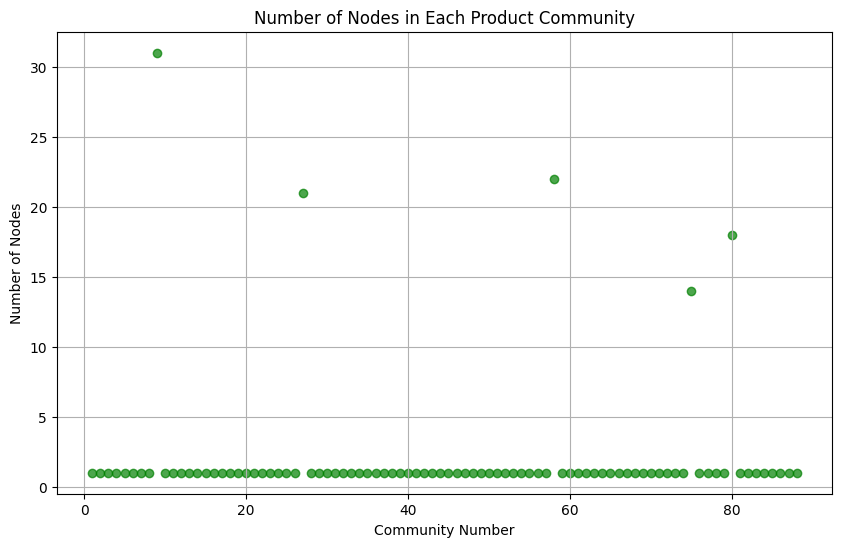

In [28]:
# Load your data
import pandas as pd
file_path = 'edited_reviews.csv'  # Update the path to your dataset
reviews_df = pd.read_csv(file_path)

# Step 1: Create the User-Product Bipartite Network
B = nx.Graph()
B.add_nodes_from(reviews_df['userId'].unique(), bipartite='user')
B.add_nodes_from(reviews_df['productId'].unique(), bipartite='product')
B.add_edges_from(reviews_df[['userId', 'productId']].drop_duplicates().itertuples(index=False, name=None))

# Step 2: Project the Bipartite Network
user_projection = nx.bipartite.projected_graph(B, [n for n, d in B.nodes(data=True) if d['bipartite'] == 'user'])
product_projection = nx.bipartite.projected_graph(B, [n for n, d in B.nodes(data=True) if d['bipartite'] == 'product'])

# Step 3: Apply Community Detection
user_communities = louvain_communities(user_projection)
product_communities = louvain_communities(product_projection)

# Define colors for communities (optional, if needed for further plotting)
colors = list(mcolors.TABLEAU_COLORS.values())

# Function to plot a graph with spring layout and community colors (optional)
def plot_community_graph(graph, communities, title):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, k=0.1, seed=42)
    for i, community in enumerate(communities):
        color = colors[i % len(colors)]
        nx.draw_networkx_nodes(graph, pos, nodelist=community, node_size=50, node_color=color, label=f'Community {i + 1}')
    nx.draw_networkx_edges(graph, pos, alpha=0.2)
    if len(graph.nodes) <= 100:
        nx.draw_networkx_labels(graph, pos, font_size=8)
    plt.legend(loc='best')
    plt.title(title)
    plt.axis('off')
    plt.show()



# Step 4: Plot the scatter plot for the number of nodes in each community

# Calculate community sizes
user_community_sizes = [len(community) for community in user_communities]
product_community_sizes = [len(community) for community in product_communities]

# Scatter plot for user community sizes
plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(user_community_sizes) + 1), user_community_sizes, color='blue', alpha=0.7)
plt.title("Number of Nodes in Each User Community")
plt.xlabel("Community Number")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()

# Scatter plot for product community sizes
plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(product_community_sizes) + 1), product_community_sizes, color='green', alpha=0.7)
plt.title("Number of Nodes in Each Product Community")
plt.xlabel("Community Number")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()





In [30]:
# Assuming user_communities is a list of sets, where each set contains the nodes (users) in a community
user_community_sizes = [len(community) for community in user_communities]

# Create a table showing the number of people in each user community
user_community_data = {
    'Community Number': range(1, len(user_community_sizes) + 1),
    'Number of Users': user_community_sizes
}
user_community_df = pd.DataFrame(user_community_data)

# Display the table
print(user_community_df)

     Community Number  Number of Users
0                   1                3
1                   2               43
2                   3                2
3                   4                1
4                   5               23
..                ...              ...
108               109                1
109               110                2
110               111                2
111               112                9
112               113                1

[113 rows x 2 columns]


In [33]:
# Calculate the size of each movie community
product_community_sizes = [len(community) for community in product_communities]

# Create a table with community number, size, and a sample of movies in each community
product_community_data = {
    'Community Number': [],
    'Number of Movies': [],
    'Sample Movies': []
}

# Populate the table with community information
for i, community in enumerate(product_communities):
    sample_movies = list(community)[:5]  # Taking a sample of 5 movies for display
    product_community_data['Community Number'].append(i + 1)
    product_community_data['Number of Movies'].append(len(community))
    product_community_data['Sample Movies'].append(sample_movies)

# Convert the dictionary to a DataFrame
product_community_df = pd.DataFrame(product_community_data)

# Display the table
print(product_community_df)

    Community Number  Number of Movies Sample Movies
0                  1                 1  [B000068QKZ]
1                  2                 1  [B0002T2QZG]
2                  3                 1  [B0007R4SU4]
3                  4                 1  [B000SK5Z84]
4                  5                 1  [6303444253]
..               ...               ...           ...
84                85                 1  [B00322R2QS]
85                86                 1  [630195503X]
86                87                 1  [B008X0ST7U]
87                88                 1  [0972928421]
88                89                 1  [0767017382]

[89 rows x 3 columns]


Movie Genre or Theme Clustering

1.Movie Communities: The product (movie) communities represent groups of movies that are often reviewed or watched by the same sets of users. This clustering might reveal hidden patterns, like which genres or themes are closely related based on user interest.

2.Genre or Theme Similarities: Movies within the same community are likely similar in some way, such as genre, mood, or actors. This can help you classify movies based on implicit audience-defined categories.

Product Communities (Clusters of Frequently Co-Reviewed Products):
Community 1: ['B000068QKZ']
Community 2: ['B0002T2QZG']
Community 3: ['B0007R4SU4']
Community 4: ['B004BP3WGO', 'B0009XT8U6']
Community 5: ['B000SK5Z84']
Community 6: ['6303444253']
Community 7: ['B002FYAGEO']
Community 8: ['B001QBV3FI']
Community 9: ['B00008V2V7']
Community 10: ['B00008V2V3']
Community 11: ['B00008V2V0']
Community 12: ['6302670241']
Community 13: ['B00008V2V9']
Community 14: ['B003VIM524']
Community 15: ['B001PXF3DU']
Community 16: ['B001PSJT44']
Community 17: ['B00811XMZ0']
Community 18: ['B00005UQE8']
Community 19: ['B0011VIO32', '6300271102', 'B00004TXKC', 'B0085BNPH6', '0780624890', 'B000I0EOLI', 'B001INEXEM', 'B0076YFJ3G', 'B000IZJQY8', 'B00004CLFR', 'B00455IVQQ', 'B000KHI046', 'B00008V2VF', 'B00008V2VE', 'B00005MAYH', 'B00005MAYG', 'B00004YA66', 'B00005QT9O']
Community 20: ['B005EIJN4W']
Community 21: ['B00701PLWY']
Community 22: ['6302892201']
Community 23: ['6301760360']
Community 24: ['B00062I

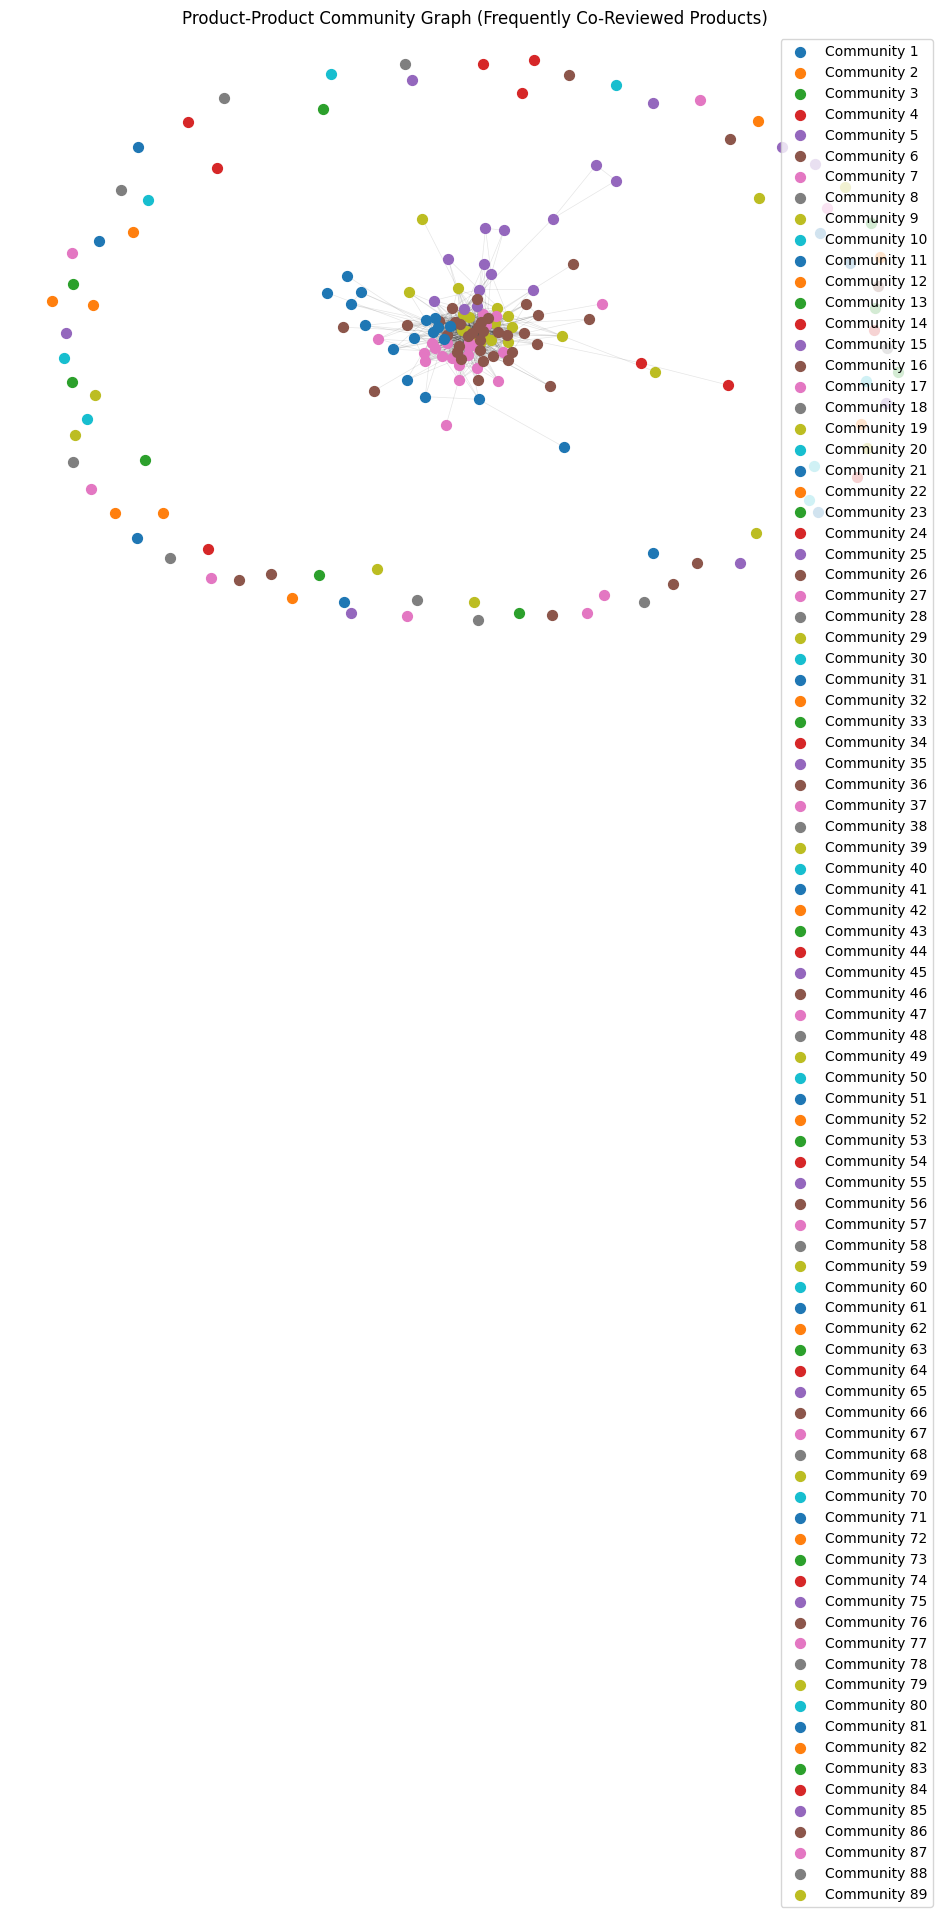

In [34]:
# Step 1: Create the User-Product Bipartite Network
B = nx.Graph()
B.add_nodes_from(reviews_df['userId'].unique(), bipartite='user')
B.add_nodes_from(reviews_df['productId'].unique(), bipartite='product')
B.add_edges_from(reviews_df[['userId', 'productId']].drop_duplicates().itertuples(index=False, name=None))

# Step 2: Project to a Product-Product Network
# In this projection, products are connected if they are reviewed by the same users
product_projection = nx.bipartite.projected_graph(B, [n for n, d in B.nodes(data=True) if d['bipartite'] == 'product'])

# Step 3: Apply Community Detection to Find Product Communities
product_communities = louvain_communities(product_projection)

# Display the product communities
print("Product Communities (Clusters of Frequently Co-Reviewed Products):")
for i, community in enumerate(product_communities):
    print(f"Community {i + 1}: {list(community)}")

# Step 4: Visualize Product Communities with Spring Layout

# Define colors for communities
colors = list(mcolors.TABLEAU_COLORS.values())

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(product_projection, k=0.2, seed=42)  # k controls spacing; adjust as needed

# Draw each community with a different color
for i, community in enumerate(product_communities):
    color = colors[i % len(colors)]
    nx.draw_networkx_nodes(product_projection, pos, nodelist=community, node_size=50, node_color=color, label=f'Community {i + 1}')

# Draw edges with low opacity for readability
nx.draw_networkx_edges(product_projection, pos, alpha=0.1, width=0.5)

# Add legend and title
plt.legend(loc='best')
plt.title("Product-Product Community Graph (Frequently Co-Reviewed Products)")
plt.axis('off')
plt.show()